In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Praca domowa 4 - SVM

## Zbiór danych apartments
Zbiór apartments z pakietu DALEX zawiera dane dotyczące mieszkań. Ramka danych posiada 5 kolumn numerycznych i 1 kategoryczną. Naszym celem jest regresja ceny mieszkania za metr kwadratowy `m2_price`.

In [3]:
from dalex.datasets import load_apartments
apts_df = load_apartments()
apts_df.head(3)

,m2_price,construction_year,surface,floor,no_rooms,district
1,5897,1953,25,3,1,Srodmiescie
2,1818,1992,143,9,5,Bielany
3,3643,1937,56,1,2,Praga


In [4]:
apts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2_price           1000 non-null   int64 
 1   construction_year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no_rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 54.7+ KB


W zbiorze danych nie brakuje żadnych wartości. Zmienne mają wartości różnego rzędu i tylko zmienna objaśniana `m2_price` posiada rozkład zbliżony do normalnego, dlatego potrzebne będzie skalowanie wartości kolumn.

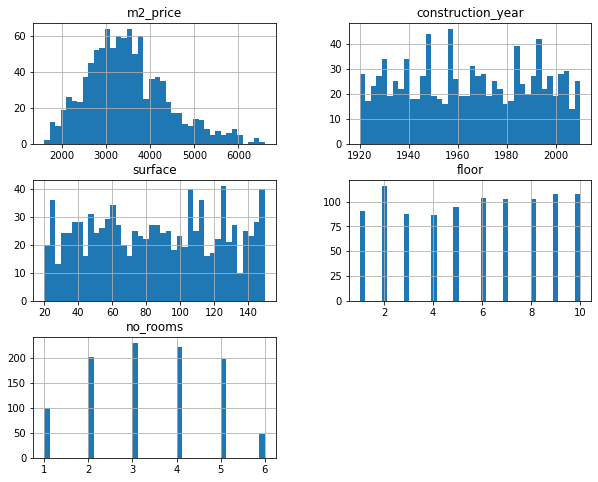

In [118]:
apts_df.hist(figsize=(10,8), bins=40)
plt.show()

## Zbiór danych breast cancer z sklearn

Kolejny zbiór danych zawiera informacje o przypadkach raka piersi. Ramka danych zawiera 30 kolumn numerycznych. Celem jest klasyfikacja próbki czy jest to nowotwór złośliwy.

In [7]:
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer(as_frame=True)
cancer_df = cancer_data['data']
cancer_target = cancer_data['target']

In [8]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [9]:
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


W zbiorze danych nie brakuje żadnych wartości. Kolumny są różnego rzędu (np. `smothness error` ma wartości w przedziale [0, 0.03], a `worst area` [0, 4000]) i wiele z nich są silnie skośne. Również tutaj potrzebne będzie skalowanie danych.

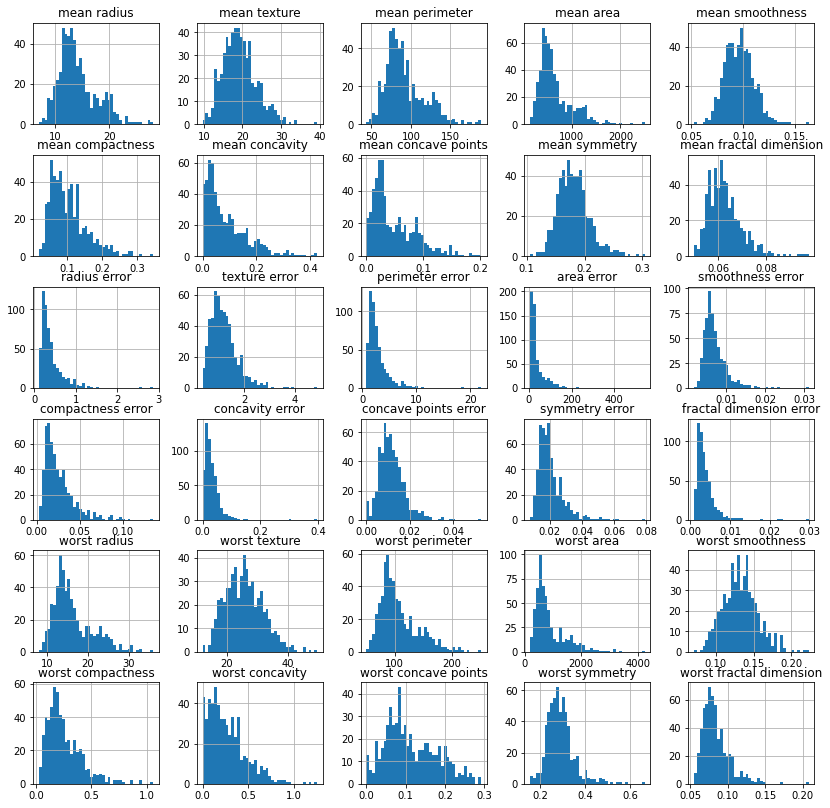

In [10]:
cancer_df.hist(figsize=(14,14), bins=40)
plt.show()

Liczebność klas jest całkiem zbalansowana.

In [11]:
cancer_target.value_counts()

1    357
0    212
Name: target, dtype: int64

## Preprocessing
Dzielimy oba zbiory danych na podzbiory treningowe i testowe. Aby zbadać wpływ skalowania danych na SVM, stworzymy dwie wersje pipeline'ów, ze skalowaniem za pomocą `StandardScaler` oraz bez. Konieczne jeszcze będzie zakodowanie dzielnic ze zbioru apartments za pomocą OneHotEncoding.

In [12]:
from sklearn.model_selection import train_test_split
x_apts_train, x_apts_test, y_apts_train, y_apts_test = train_test_split(
    apts_df.drop(columns=['m2_price']), apts_df['m2_price'], test_size=0.2, random_state=42)

x_cancer_train, x_cancer_test, y_cancer_train, y_cancer_test = train_test_split(
    cancer_df, cancer_target, test_size=0.2, random_state=42)

In [13]:
# apartments
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessing_apts = ColumnTransformer([('onehot', OneHotEncoder(), ['district'])], remainder='passthrough')

preprocessing_apts_scaled = ColumnTransformer([('onehot', OneHotEncoder(), ['district'])], remainder=StandardScaler())

In [14]:
# breast cancer

# W danych breast cancer sa tylko dane numeryczne, wiec w przypadku wersji bez skalowania
#  nie potrzeba tworzyc pipeline'nu z preprocessingiem

preprocessing_cancer_scaled = StandardScaler()

## Wpływ skalowania - zbiór apartments
Sprawdźmy teraz działanie modelu regersji w zależności czy korzysta z danych przeskalowanych lub nieprzeskalowanych.

In [51]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

apts_model = make_pipeline(preprocessing_apts, SVR())
apts_model.fit(x_apts_train, y_apts_train)
print('Unscaled data - train score: ', mean_squared_error(y_apts_train, apts_model.predict(x_apts_train), squared=False))
print('Unscaled data - test score: ', mean_squared_error(y_apts_test, apts_model.predict(x_apts_test), squared=False))

Unscaled data - train score:  898.5448498842396
Unscaled data - test score:  973.966883319658


In [52]:
apts_model_scaled = make_pipeline(preprocessing_apts_scaled, SVR())
apts_model_scaled.fit(x_apts_train, y_apts_train)
print('Scaled data - train score: ', mean_squared_error(y_apts_train, apts_model_scaled.predict(x_apts_train), squared=False))
print('Scaled data - test score: ', mean_squared_error(y_apts_test, apts_model_scaled.predict(x_apts_test), squared=False))

Scaled data - train score:  874.5345230482917
Scaled data - test score:  953.3722122304314


Model ze skalowaniem danych poradził sobie nieco lepiej. Różnica pomiędzy wynikiem na zbiorze testowym i treningowym pozostała mniej więcej taka sama, co wskazuje że skalowanie nie wpłynęło na zjawisko przeuczenia/niedouczenia. Porównując powyższe błędy do wartości jakie są osiągane przez zmienną objaśnianą, można stwierdzić że różnice pomiędzy modelami są nieznaczne.

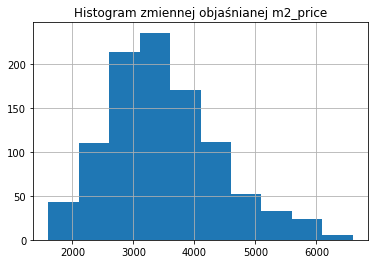

In [54]:
apts_df.m2_price.hist()
plt.title('Histogram zmiennej objaśnianej m2_price')
plt.show()

## Wpływ skalowania - zbiór breast cancer
Analogiczny test przeprowadźmy dla klasyfikacji zbioru breast cancer. Dla porównania działania wykorzystamy trzy metryki, dokładność, czułość i metrykę F1, która jest średnią harmoniczną precyzji i czułości. Będzięmy mierzyć wyniki również dla zbioru treningowego aby zbadać występowanie overfittingu.

In [126]:
from sklearn.metrics import f1_score
from sklearn.svm import SVC

cancer_model = SVC()
cancer_model.fit(x_cancer_train, y_cancer_train)


results = []

results.append({'data':'unscaled', 'dataset':'train', 'metric':'acc',
           'value': accuracy_score(y_cancer_train, cancer_model.predict(x_cancer_train))})

results.append({'data':'unscaled', 'dataset':'test', 'metric':'acc',
           'value': accuracy_score(y_cancer_test, cancer_model.predict(x_cancer_test))})

results.append({'data':'unscaled', 'dataset':'train', 'metric':'f1',
           'value': f1_score(y_cancer_train, cancer_model.predict(x_cancer_train))})

results.append({'data':'unscaled', 'dataset':'test', 'metric':'f1',
           'value': f1_score(y_cancer_test, cancer_model.predict(x_cancer_test))})

results.append({'data':'unscaled', 'dataset':'train', 'metric':'recall',
           'value': recall_score(y_cancer_train, cancer_model.predict(x_cancer_train))})

results.append({'data':'unscaled', 'dataset':'test', 'metric':'recall',
           'value': recall_score(y_cancer_test, cancer_model.predict(x_cancer_test))})



In [127]:
cancer_model_scaled = make_pipeline(preprocessing_cancer_scaled, SVC())
cancer_model_scaled.fit(x_cancer_train, y_cancer_train)

results.append({'data':'scaled', 'dataset':'train', 'metric':'acc',
           'value': accuracy_score(y_cancer_train, cancer_model_scaled.predict(x_cancer_train))})

results.append({'data':'scaled', 'dataset':'test', 'metric':'acc',
           'value': accuracy_score(y_cancer_test, cancer_model_scaled.predict(x_cancer_test))})

results.append({'data':'scaled', 'dataset':'train', 'metric':'f1',
           'value': f1_score(y_cancer_train, cancer_model_scaled.predict(x_cancer_train))})

results.append({'data':'scaled', 'dataset':'test', 'metric':'f1',
           'value': f1_score(y_cancer_test, cancer_model_scaled.predict(x_cancer_test))})

results.append({'data':'scaled', 'dataset':'train', 'metric':'recall',
           'value': recall_score(y_cancer_train, cancer_model_scaled.predict(x_cancer_train))})

results.append({'data':'scaled', 'dataset':'test', 'metric':'recall',
           'value': recall_score(y_cancer_test, cancer_model_scaled.predict(x_cancer_test))})

all_results_df = pd.DataFrame(results).set_index(['metric', 'dataset', 'data']).sort_index(level=0)
all_results_df.style.background_gradient(cmap='Blues')

Jak można było się spodziewać, skalowanie poprawiło wyniki dla każdej metryki dla każdego zbioru. Największa poprawa wyniku zbioru testowego jest dla metryki dokładności. Jest tu poprawa o 3.5 p.p. W przypadku danych przeskalowanych i nieprzeskalowanych overfitting nie występuje. Co ciekawe dla danych nieprzeskalowanych model uzyskiwał lepszą czułość dla zbioru testowego niż treningowego.

## RandomSearch - apartments
Poszukajmy teraz najlepszych hiperparametrów dla zagadnienia regresji z danymi apartments przy użyciu `RandomizedSearchCV`. Modele SVM korzystają z różnego rodzaju jąder, między innymi z RBF i wielomianowych. Każde z nich posiada własny parametr, odpowiednio `gamma` i `poly`. Aby niepotrzebnie nie marnować czasu na iteracje parametru `gamma` w przypadku gdy wybrane jest jądro `poly`, rozdzielimy przeszukiwania na te jądrem `rbf` i `poly`.

#### Jądro RBF

In [119]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

param_dist = {'svr__C': stats.loguniform(0.0001, 1000),
              'svr__gamma': ['scale', 'auto', 0.001, 1],
              'svr__kernel':['rbf']}

apts_model_scaled = make_pipeline(preprocessing_apts_scaled, SVR())

search = RandomizedSearchCV(apts_model_scaled, param_dist,
                            cv=4, scoring ='neg_root_mean_squared_error', n_iter= 80, n_jobs=-1, verbose=3)
search.fit(x_apts_train, y_apts_train)
model_apts_rbf = search.best_estimator_


Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    6.9s finished


In [120]:
print('Best hyperparameters rbf: ', search.best_params_)
print('Train rbf score: ', mean_squared_error(y_apts_train, model_apts_rbf.predict(x_apts_train), squared=False))
print('Test rbf score: ', mean_squared_error(y_apts_test, model_apts_rbf.predict(x_apts_test), squared=False))

Best hyperparameters rbf:  {'svr__C': 679.8915832908714, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
Train rbf score:  156.6930492475548
Test rbf score:  174.89137675031031


#### Jądro wielomianowe

In [121]:
param_dist = {'svr__C': stats.loguniform(0.0001, 1000),
              'svr__degree': stats.randint(2, 10),
              'svr__kernel':['poly']}

apts_model_scaled = make_pipeline(preprocessing_apts_scaled, SVR())

search = RandomizedSearchCV(apts_model_scaled, param_dist,
                            cv=4, scoring ='neg_root_mean_squared_error', n_iter= 80, n_jobs=-1, verbose=3)
search.fit(x_apts_train, y_apts_train)
model_apts_poly = search.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 313 out of 320 | elapsed:    4.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    4.4s finished


In [122]:
print('Best hyperparameters poly: ', search.best_params_)
print('Train poly score: ', mean_squared_error(y_apts_train, model_apts_poly.predict(x_apts_train), squared=False))
print('Test poly score: ', mean_squared_error(y_apts_test, model_apts_poly.predict(x_apts_test), squared=False))

Best hyperparameters poly:  {'svr__C': 293.85392496847686, 'svr__degree': 2, 'svr__kernel': 'poly'}
Train poly score:  294.55274311370266
Test poly score:  350.7930992568271


Najlepszy się okazał model z jądrem RBF o parametrach `C`=679.89 i `gamma`='auto' (co wg. dokumnetacji oznacza wartość 1/liczba_kolumn). Błąd dla zbioru testowego wynosi 174.9 i jest ponad 5 razy mniejszy niż modelu SVR z domyślnymi parametrami. Mała różnica w wyniku pomiędzy zbiorem treningowym i testowym wskazuje na dobrą generalizację.

In [124]:
model_apts = model_apts_rbf

## RandomSearch - breast cancer

Analogicznie postępujemy przy zadaniu klasyfikacji. Przy dobieraniu modelu i hiperparametrów będziemy korzystać z metryki F1.

#### Jądro RBF

In [35]:
param_dist = {'svc__C': stats.loguniform(0.0001, 1000),
              'svc__gamma': ['scale', 'auto', 0.001, 1],
              'svc__kernel':['rbf']}

cancer_model_scaled = make_pipeline(preprocessing_cancer_scaled, SVC())

search = RandomizedSearchCV(cancer_model_scaled, param_dist,
                            cv=4, scoring ='f1', n_iter= 80, n_jobs=-1, verbose=3)
search.fit(x_cancer_train, y_cancer_train)
model_cancer_rbf = search.best_estimator_

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    1.3s finished


In [37]:
print('Best hyperparameters rbf: ', search.best_params_)
print('Train rbf F1 score: ', f1_score(y_cancer_train, model_cancer_rbf.predict(x_cancer_train)))
print('Test rbf F1 score: ', f1_score(y_cancer_test, model_cancer_rbf.predict(x_cancer_test)))

Best hyperparameters rbf:  {'svc__C': 3.0200173164153066, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Train rbf F1 score:  0.994782608695652
Test rbf F1 score:  0.9861111111111112


#### Jądro wielomianowe

In [39]:
param_dist = {'svc__C': stats.loguniform(0.0001, 1000),
              'svc__degree': stats.randint(2, 10),
              'svc__kernel':['poly']}

cancer_model_scaled = make_pipeline(preprocessing_cancer_scaled, SVC())

search = RandomizedSearchCV(cancer_model_scaled, param_dist,
                            cv=4, scoring ='f1', n_iter= 80, n_jobs=-1, verbose=3)
search.fit(x_cancer_train, y_cancer_train)
model_cancer_poly = search.best_estimator_

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    1.1s finished


In [40]:
print('Best hyperparameters poly: ', search.best_params_)
print('Train poly F1 score: ', f1_score(y_cancer_train, model_cancer_poly.predict(x_cancer_train)))
print('Test poly F1 score: ', f1_score(y_cancer_test, model_cancer_poly.predict(x_cancer_test)))

Best hyperparameters poly:  {'svc__C': 32.51390464428388, 'svc__degree': 3, 'svc__kernel': 'poly'}
Train poly F1 score:  0.9913344887348353
Test poly F1 score:  0.9583333333333334


W przypadku naszego zadania klasyfikacji, tutaj również lepiej zadziałał model z jądrem RBF. Najlepsze znalezione parametry to `C`=3.02 i `gamma`='auto'. Ponadto model ten ma mniejszą różnicę w wyniku (niecały 1%). Jadnakże wynik dla zbioru testowego jest identyczny z wynikiem modelu z domyślnymi parametrami (F1 = 0.98611), więc w tym przypadku domyślne parametry były bliskie optymalnym.

In [125]:
model_cancer = model_cancer_rbf